In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
# import scipy.optimize as sco
import plotly.graph_objects as go
import plotly.express as px
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
plt.style.use('seaborn') 
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')


C:\Users\ssora\AppData\Local\Temp\ipykernel_19940\166870695.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Import data function
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    stockData = stockData.round(2)
    stockData.dropna(inplace=True)
    stockData.reset_index(inplace=True)
    stockData.set_index("Date", inplace=True)

    return stockData

In [3]:
stock_list = ['AOT', 'AU', 'BBL', 'BDMS', 'CPALL',
              'CRC', 'GPSC', 'HANA', 'SCGP','SECURE']
stock = [stock+'.BK' for stock in stock_list]

startDate = dt.datetime(2021, 7, 1)
endDate = dt.datetime(2022, 12, 31)

df = getData(stock, startDate, endDate)
df.head()

[*********************100%***********************]  10 of 10 completed


,AOT.BK,AU.BK,BBL.BK,BDMS.BK,CPALL.BK,CRC.BK,GPSC.BK,HANA.BK,SCGP.BK,SECURE.BK
Date,,,,,,,,,,
2021-07-01,62.50,10.5,114.0,23.7,60.25,34.25,75.50,70.50,61.25,24.20
2021-07-02,62.25,10.5,112.0,23.4,59.75,34.00,74.50,69.75,61.75,27.25
2021-07-05,61.75,10.4,112.0,23.6,59.50,34.25,76.75,70.75,63.75,29.75
2021-07-06,62.25,10.4,112.0,23.4,60.00,35.00,76.25,70.75,63.25,30.00
2021-07-07,61.75,10.4,108.0,23.5,60.25,34.00,75.50,71.75,63.25,27.75


# Long Position Only

In [4]:
# risk free rate
risk_free = 0.02

# portfolio type
long_only = tuple([0,1])
long_short = tuple([-1,1])

port_type = long_only # edit here

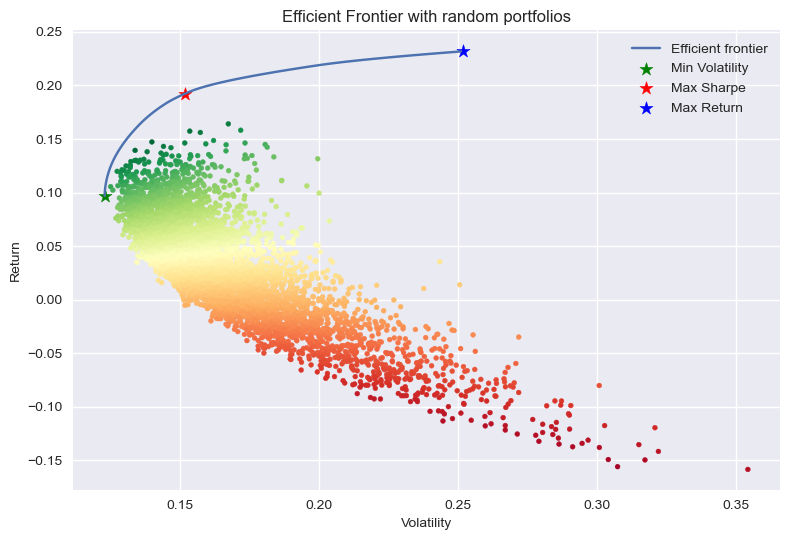

In [5]:
# portfolio weight constraint
# Calculate expected returns and sample covariance
expected_returns = expected_returns.mean_historical_return(df)
cov_matrix = risk_models.sample_cov(df)

ef = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=port_type)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

ef = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=port_type)

# Min volatility
ef_minvol = ef.deepcopy()
ef_minvol.min_volatility()
ret_minvol, std_minvol, _ = ef_minvol.portfolio_performance()
ax.scatter(std_minvol, ret_minvol, marker="*", s=100, c="g", label="Min Volatility")

# Max Sharpe Ratio
ef_ms = ef.deepcopy()
ef_ms.max_sharpe(risk_free_rate=risk_free)
ret_ms, std_ms, _ = ef_ms.portfolio_performance()
ax.scatter(std_ms, ret_ms, marker="*", s=100, c="r", label="Max Sharpe")

# Max return
ef_mr = ef.deepcopy()
ef_mr.max_quadratic_utility(risk_aversion=0.01)
ret_maxret, std_maxret, _ = ef_mr.portfolio_performance()
ax.scatter(std_maxret, ret_maxret, marker="*", s=100, c="b", label="Max Return")


# Generate random portfolios
n_samples = 5000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="RdYlGn")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()



In [6]:
print('===== Min Volatility =====')
ef_minvol.portfolio_performance(verbose=True)
print('\n===== Max Sharpe =====')
ef_ms.portfolio_performance(verbose=True)
print('\n===== Max Return =====')
ef_mr.portfolio_performance(verbose=True)

===== Min Volatility =====
Expected annual return: 9.7%
Annual volatility: 12.3%
Sharpe Ratio: 0.63

===== Max Sharpe =====
Expected annual return: 19.2%
Annual volatility: 15.2%
Sharpe Ratio: 1.14

===== Max Return =====
Expected annual return: 23.2%
Annual volatility: 25.2%
Sharpe Ratio: 0.84


(0.2318595411282434, 0.2517547652245371, 0.8415314043382193)

In [7]:
own_weights = np.array([0.1]*10)
minvol_weights = ef_minvol.clean_weights()
ms_weights = ef_ms.clean_weights()
maxret_weights = ef_mr.clean_weights()

# stock and own_weights to dataframe
df_port_weigths = pd.DataFrame(own_weights, index=df.columns, columns=['Own (%)'])
df_port_weigths['Min Volatility (%)'] = minvol_weights.values()
df_port_weigths['Max Sharpe (%)'] = ms_weights.values()
df_port_weigths['Max Return (%)'] = maxret_weights.values()
df_port_weigths = (df_port_weigths*100).round(2)
df_port_weigths


,Own (%),Min Volatility (%),Max Sharpe (%),Max Return (%)
AOT.BK,10.0,17.45,2.31,0.0
AU.BK,10.0,5.63,0.00,0.0
BBL.BK,10.0,16.56,38.49,0.0
BDMS.BK,10.0,22.36,30.28,0.0
CPALL.BK,10.0,16.81,0.00,0.0
CRC.BK,10.0,0.00,28.93,100.0
GPSC.BK,10.0,6.76,0.00,0.0
HANA.BK,10.0,2.07,0.00,0.0
SCGP.BK,10.0,12.36,0.00,0.0
SECURE.BK,10.0,0.00,0.00,0.0


# Returns and volatility of each portfolio between January 3, 2023 and April 30, 2023.

In [8]:
# get new data 
startDate2 = dt.datetime(2023, 1, 1)
endDate2 = dt.datetime(2023, 4, 30)

df2 = getData(stock, startDate2, endDate2)
df2.head()

[*********************100%***********************]  10 of 10 completed


,AOT.BK,AU.BK,BBL.BK,BDMS.BK,CPALL.BK,CRC.BK,GPSC.BK,HANA.BK,SCGP.BK,SECURE.BK
Date,,,,,,,,,,
2023-01-03,75.00,12.1,151.0,29.25,69.50,46.25,72.75,53.50,57.25,14.5
2023-01-04,74.50,12.2,153.5,29.50,69.00,47.50,75.00,52.00,57.75,14.7
2023-01-05,75.00,12.0,152.5,29.50,69.00,46.00,74.75,51.00,60.00,15.2
2023-01-06,75.50,12.4,157.0,30.25,70.25,46.25,75.00,58.25,59.25,15.1
2023-01-09,75.25,12.4,157.5,30.25,73.00,46.25,75.25,58.00,59.00,15.4


In [9]:
own_port = dict(zip(stock, own_weights))

df2['Own'] = 0
df2['Min Volatility'] = 0
df2['Max Sharpe'] = 0
df2['Max Return'] = 0

for ticker, weight in own_port.items():
    df2['Own'] += df2[ticker] * weight

for ticker, weight in minvol_weights.items():
    df2['Min Volatility'] += df2[ticker] * weight

for ticker, weight in ms_weights.items():
    df2['Max Sharpe'] += df2[ticker] * weight

for ticker, weight in maxret_weights.items():
    df2['Max Return'] += df2[ticker] * weight


df_port = df2[['Own', 'Min Volatility', 'Max Sharpe', 'Max Return']]
df_port.head()


,Own,Min Volatility,Max Sharpe,Max Return
Date,,,,
2023-01-03,58.110,70.097451,82.083565,46.25
2023-01-04,58.565,70.584305,83.471525,47.50
2023-01-05,58.495,70.735308,82.664270,46.00
2023-01-06,59.925,72.042364,84.707195,46.25
2023-01-09,60.230,72.524699,84.893870,46.25


In [10]:
# daily percentage change
df_port_pct = df_port.pct_change()

# plot daily percentage change
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_port_pct.index, y=df_port_pct['Own'], name='Own'))
fig.add_trace(go.Scatter(x=df_port_pct.index, y=df_port_pct['Min Volatility'], name='Min Volatility'))
fig.add_trace(go.Scatter(x=df_port_pct.index, y=df_port_pct['Max Sharpe'], name='Max Sharpe'))
fig.add_trace(go.Scatter(x=df_port_pct.index, y=df_port_pct['Max Return'], name='Max Return'))
fig.update_layout(title='Portfolio Performance', yaxis_title='Daily Returns', xaxis_title='Date')
fig.show()

In [11]:
# daily percentage change standard deviation
df_port_pct.std()

Own               0.008970
Min Volatility    0.008421
Max Sharpe        0.011370
Max Return        0.015033
dtype: float64

In [12]:
# cumulative return
df_port_cum = (df_port_pct + 1).cumprod()

# fill 1st row with 1
df_port_cum.iloc[0] = 1
df_port_cum.head()

,Own,Min Volatility,Max Sharpe,Max Return
Date,,,,
2023-01-03,1.000000,1.000000,1.000000,1.000000
2023-01-04,1.007830,1.006945,1.016909,1.027027
2023-01-05,1.006625,1.009100,1.007075,0.994595
2023-01-06,1.031234,1.027746,1.031963,1.000000
2023-01-09,1.036483,1.034627,1.034237,1.000000


In [13]:
# plot cumulative return
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_port_cum.index, y=df_port_cum['Own'], name='Own'))
fig.add_trace(go.Scatter(x=df_port_cum.index, y=df_port_cum['Min Volatility'], name='Min Volatility'))
fig.add_trace(go.Scatter(x=df_port_cum.index, y=df_port_cum['Max Sharpe'], name='Max Sharpe'))
fig.add_trace(go.Scatter(x=df_port_cum.index, y=df_port_cum['Max Return'], name='Max Return'))
fig.update_layout(title='Portfolio Performance', yaxis_title='Cumulative Returns', xaxis_title='Date')
fig.show()

In [14]:
# df_port_cum.iloc[-1] and df_port_pct.std() to dataframe
df_port_ret_std = pd.concat([df_port_cum.iloc[-1], df_port_pct.std()], axis=1)
df_port_ret_std.columns = ['Return (%)', 'Std']
df_port_ret_std['Return (%)'] = ((df_port_ret_std['Return (%)']-1)*100).round(2)
df_port_ret_std['Std'] = df_port_ret_std['Std'].round(4)
# set index name
df_port_ret_std.index.name = 'Portfolio'
df_port_ret_std

,Return (%),Std
Portfolio,,
Own,-6.52,0.0090
Min Volatility,-3.81,0.0084
Max Sharpe,2.24,0.0114
Max Return,-3.24,0.0150


In [15]:
# plot for return and std
fig = px.scatter(df_port_ret_std, x='Std', y='Return (%)', text=df_port_ret_std.index, size=[1]*4, color=df_port_ret_std.index)
fig.update_layout(title='Return (%) vs Standard Deviation', yaxis_title='Return (%)', xaxis_title='Standard Deviation')
fig.show()